[*********************100%***********************]  11 of 11 completed


Linear Regression table for expected returns and risk:
         Alpha    Beta  Expected Return(Annual)  Idiosyncratic Variance
Stock                                                                  
BRK-A  0.00033 0.55134                  0.10994                 0.00008
AAPL  -0.00055 1.19787                  0.21541                 0.00015
MSFT   0.00018 1.02895                  0.18786                 0.00010
JPM    0.00100 0.90744                  0.16803                 0.00013
GOOG   0.00014 1.12389                  0.20335                 0.00022
BAC    0.00056 0.99130                  0.18172                 0.00017
INTC  -0.00141 1.70280                  0.29779                 0.00080
WFC    0.00089 0.98917                  0.18137                 0.00023
C      0.00066 1.19319                  0.21465                 0.00018
VZ     0.00049 0.14123                  0.04304                 0.00021


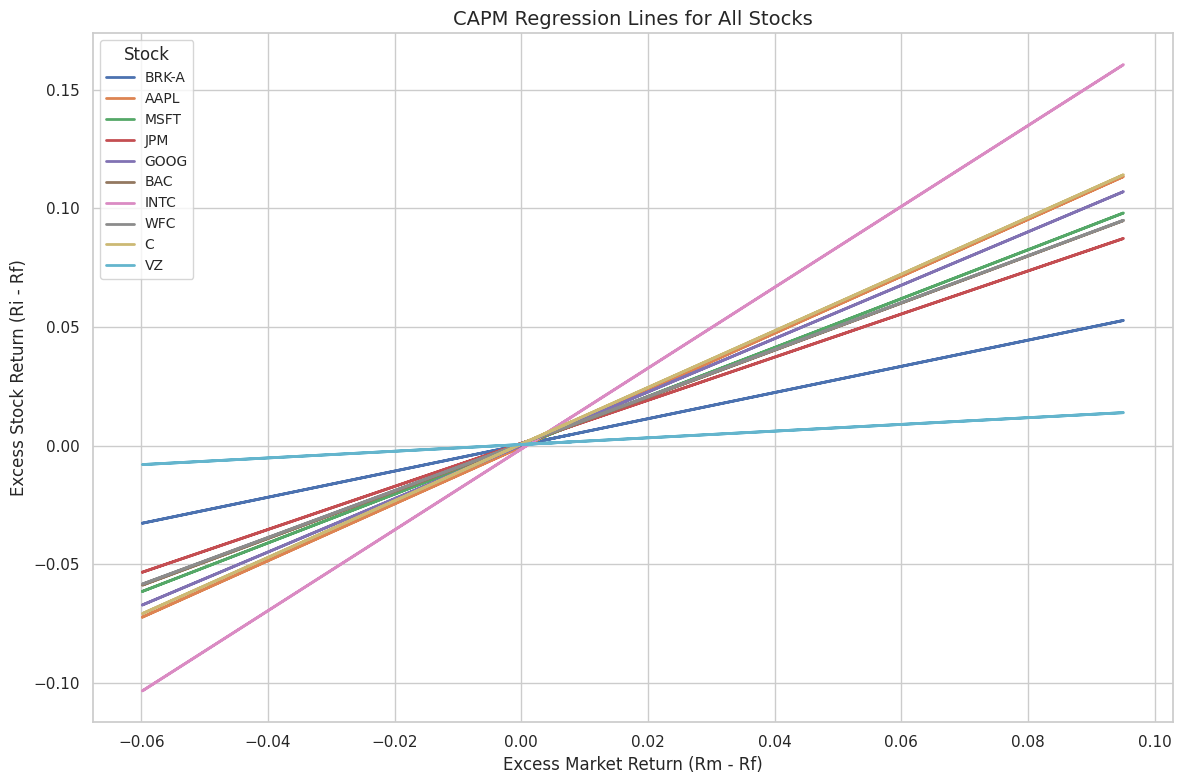

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
from sklearn.linear_model import LinearRegression

stocks = ['BRK-A', 'AAPL', 'MSFT', 'JPM', 'GOOG', 'BAC', 'INTC', 'WFC','C', 'VZ']       #Defining stock tickers and time frame


tickers = stocks + ['^GSPC']                                                            #Downloading stock and market index data
data = yf.download(tickers, period='2y')                                                #Downloading the data of stocks of 2 years
adj_close = data['Close']


daily_returns = adj_close.pct_change().dropna()                                         # Calculating daily returns of each asset
daily_market_returns = daily_returns['^GSPC']   #Calculating returns of S&P 500
average_market_return = daily_market_returns.mean() #Mean of daily market return

# Risk-free rate has been calculated of per day
risk_free_rate = 0.02 / 252

#declaring am empty array of results
results = []

# Performing linear regression to get values of alpha and beta
for stock in stocks:
    daily_returnss = daily_returns[stock]                                                #fetches the daily return of current stock

    stock_excess = daily_returnss - risk_free_rate                                       #Ri-Rf
    market_excess = daily_market_returns - risk_free_rate                               #Rm-Rf

    df = pd.concat([stock_excess, market_excess], axis=1).dropna()                      #Creating a dataframe with two columns stock excess and market excess
    df.columns = ['stock', 'market']

    X = df['market'].values.reshape(-1, 1)                                              #X is independent variable of market excess return
    y = df['stock'].values.reshape(-1, 1)                                               #y is dependent variable of stock excess return

    model = LinearRegression().fit(X, y)                                                #Fitting a linear regression
    alpha = model.intercept_[0]
    beta = model.coef_[0][0]

    # Expected return using CAPM (annualized)
    expected_return = risk_free_rate + beta *  (average_market_return - risk_free_rate)  #Ri-Rf = alpha+beta(Rm-Rf) + error term
    expected_return_annual = expected_return * 252                                     #Annualized return

    # Residuals and idiosyncratic variance
    residuals = y - model.predict(X)                                                   #Yi-(alpha+beta*(X))
    idio_var = np.var(residuals, ddof=1)                                                #variance*residuals

    # combining the results of alpha,beta,Returns and Idiosyncratic variance
    results.append({
        'Stock': stock,
        'Alpha': alpha,
        'Beta': beta,
        'Expected Return(Annual)': expected_return_annual,
        'Idiosyncratic Variance': idio_var
    })

# Converting the above results to DataFrame

resultsdf = pd.DataFrame(results)
resultsdf.set_index('Stock', inplace=True)

# Format the table and convert the values to 5 d.p
pd.options.display.float_format = '{:.5f}'.format

# Display results of linear regression in a table
print("Linear Regression table for expected returns and risk:")
print(resultsdf)


#importing the libraries to plot a graph
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

#Plotting the regression results of each stock
for result in results:
    stock = result['Stock']
    alpha = result['Alpha']
    beta = result['Beta']

    # Recreate excess returns for this stock
    stock_excess = daily_returns[stock] - risk_free_rate
    market_excess = daily_market_returns - risk_free_rate

    df = pd.concat([stock_excess, market_excess], axis=1).dropna()
    df.columns = ['stock', 'market']

    X = df['market'].values.reshape(-1, 1)
    y = df['stock'].values.reshape(-1, 1)

    # Creating the regression line
    y_pred = alpha + beta * X

    # Plot regression line with label
    plt.plot(X, y_pred, label=stock, linewidth=2)

# Mentioning the title, labels and legends
plt.title('CAPM Regression Lines for All Stocks', fontsize=14)
plt.xlabel('Excess Market Return (Rm - Rf)', fontsize=12)
plt.ylabel('Excess Stock Return (Ri - Rf)', fontsize=12)
plt.legend(title="Stock", loc='best', fontsize=10)
plt.tight_layout()
plt.show()


In [19]:
# Extract data from results_df (make sure results_df is already defined)
stocks = list(resultsdf.index)

#converting the beta, variance and return values to dictionary
beta = resultsdf['Beta'].to_dict()
idio_var = resultsdf['Idiosyncratic Variance'].to_dict()
expected_returns = resultsdf['Expected Return(Annual)'].to_dict()

#assuming that we have 252 working days
sigma_m2 = daily_market_returns.var() * 252

# Creating vectors
beta_vec = np.array([beta[s] for s in stocks])

idio_var_vec = np.array([idio_var[s] for s in stocks])

mu_vec = np.array([expected_returns[s] for s in stocks])

n = len(stocks) #finding the length of stocks

#Building covariance matrix using CAPM factor model
Sigma = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i == j:
            Sigma[i, i] = (beta_vec[i]**2) * sigma_m2 + idio_var_vec[i]
        else:
            Sigma[i, j] = beta_vec[i] * beta_vec[j] * sigma_m2


#Printing the results of expected returns of the stocks and their minimum and maximum values
print("Expected returns:", mu_vec)
print("-----------------------------------------------------")
print("Minimum:", np.min(mu_vec), "Maximum:", np.max(mu_vec))
print("-----------------------------------------------------")
mu_p = np.mean(mu_vec)

# Regularizing covariance matrix to avoid the numerical issues

Sigma += 1e-6 * np.eye(n)

#Setting average expected return
mu_p = np.mean(mu_vec)

# Defining optimization variables
w = cp.Variable(n)

# Defining objective and constraints
objectives = cp.Minimize(0.5 * cp.quad_form(w, Sigma))

constraint = [
    w @ mu_vec == mu_p,
    cp.sum(w) == 1,      # weights sum to 1
    w >= 0               #Without short selling
]



# Solving portfolio optimization

problem = cp.Problem(objectives, constraint)
problem.solve()

# Display results
if problem.status != cp.OPTIMAL:
    print("⚠️ Optimization problem infeasible or did not converge.")
else:
    optimal_weights = w.value
    print("Optimal Portfolio Weights:")
    for i, stock in enumerate(stocks):
        print(f"{stock}: {optimal_weights[i]:.4f}") #printing the values and converting them to 4.d.p


Expected returns: [0.10994271 0.21541396 0.18785806 0.16803499 0.20334566 0.18171652
 0.29778581 0.18136908 0.21465144 0.04303919]
-----------------------------------------------------
Minimum: 0.04303919219674081 Maximum: 0.29778581414786676
-----------------------------------------------------
Optimal Portfolio Weights:
BRK-A: 0.1441
AAPL: 0.1296
MSFT: 0.1744
JPM: 0.1205
GOOG: 0.0854
BAC: 0.0994
INTC: 0.0330
WFC: 0.0757
C: 0.1086
VZ: 0.0294


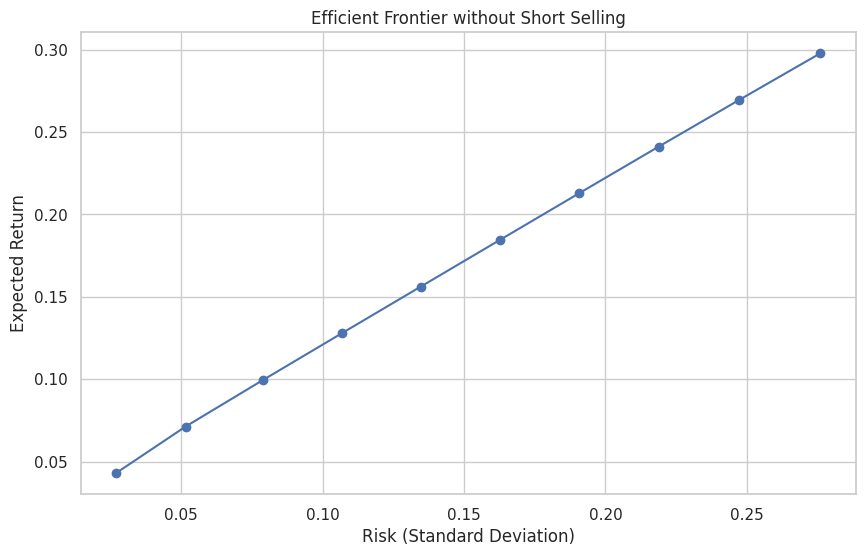

In [20]:
#Efficient Frontier without short selling

# Generating 10 equally spaced different values
target_returns = np.linspace(np.min(mu_vec), np.max(mu_vec), 10)

#Defining variables
portfolio_risks = []
portfolio_returns = []

for mu_target in target_returns:
    # Define optimization variables
    w = cp.Variable(n)

    # Updating objective and constraints for efficient frontier by applying the formula
    objective = cp.Minimize(0.5 * cp.quad_form(w, Sigma))
    constraints = [
        w @ mu_vec >= mu_target,
        cp.sum(w) == 1,
        w >= 0
    ]

    # Solving the optimization
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Storing portfolio return and risk

    if w.value is not None:
        port_return = w.value @ mu_vec
        port_risk = np.sqrt(w.value.T @ Sigma @ w.value)
        portfolio_returns.append(port_return)
        portfolio_risks.append(port_risk)
    else:
        portfolio_returns.append(np.nan)
        portfolio_risks.append(np.nan)

# Plotting Efficient Frontier and adding the customizarion to the graph

plt.figure(figsize=(10, 6))
plt.plot(portfolio_risks, portfolio_returns, marker='o', linestyle='-', color='b')

#Plotting labels
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier without Short Selling')
plt.grid(True)
plt.show()


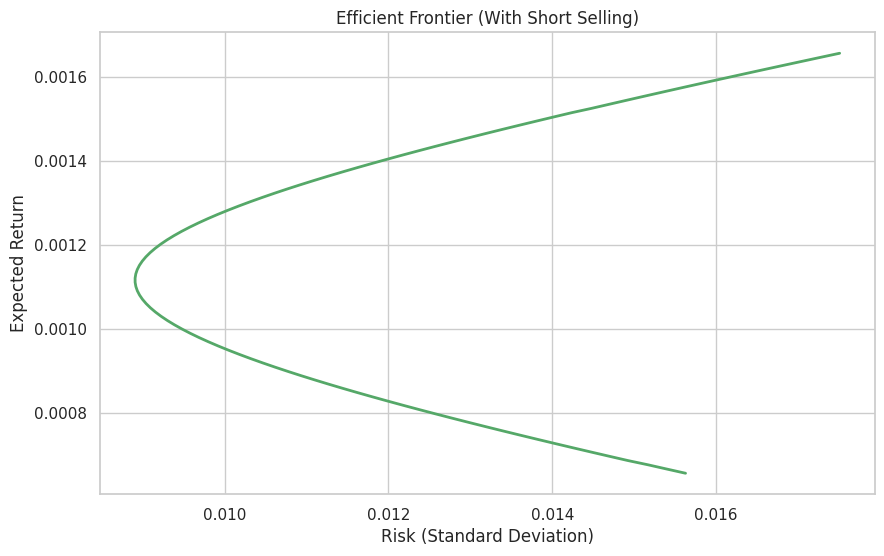

In [24]:
#Efficient Frontier with short selling

#importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Simulating the asset returns

np.random.seed(42)

n_assets = 5

n_obs = 1000

# Simulating daily returns for 5 assets
returns = np.random.randn(n_obs, n_assets) * 0.02 + 0.001

# finding Covariance matrix and mean returns
meanreturns = np.mean(returns, axis=0)
covMatrix = np.cov(returns.T)

# Portfolio statistics by defining a function
def portfolio_performance(weights, meanreturns, covMatrix):
    returns = np.dot(weights, meanreturns)
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)))
    return returns, std

# Efficient frontier calculation using the formula with short selling
def get_efficient_frontier(meanreturns, covMatrix, n_points=100):
    results = {'returns': [], 'std_devs': [], 'weights': []}
    targetReturns = np.linspace(min(meanreturns), max(meanreturns), n_points)

    n_assets = len(meanreturns)

    bounds = [(None, None)] * n_assets

    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    for target in targetReturns:
        constraints_target = constraints + [{'type': 'eq', 'fun': lambda x, target=target: np.dot(x, meanreturns) - target}]

        result = minimize(
            lambda w: np.sqrt(np.dot(w.T, np.dot(covMatrix, w))),
            x0=np.ones(n_assets) / n_assets,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints_target
        )

        if result.success:
            ret, std = portfolio_performance(result.x, meanreturns, covMatrix)
            results['returns'].append(ret)
            results['std_devs'].append(std)
            results['weights'].append(result.x)

    return results

# Plotting the graph of efficient frontier with short selling
ef_fr = get_efficient_frontier(meanreturns, covMatrix)

plt.figure(figsize=(10, 6))
plt.plot(ef_fr['std_devs'], ef_fr['returns'], 'g-', lw=2)

plt.xlabel('Risk (Standard Deviation)')

plt.ylabel('Expected Return')

plt.title('Efficient Frontier (With Short Selling)')

plt.grid(True)

plt.show()
